In [ ]:
# Import tensorflow and additional libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.keras.backend.clear_session()

# Check version
print('tensorflow version: ', tf.__version__)

tensorflow version:  2.5.0


In [ ]:
# Load : Fashion MNIST Dataest
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

size_of_train  = len(x_train)
size_of_test  = len(x_test)
num_of_class = 10

print('The Shape of dataset:', x_train[0].shape)
print('The number of train image:', size_of_train)
print('The number of test image:', size_of_test)

4423680/4422102 [==============================] - 0s 0us/step
The Shape of dataset: (28, 28)
The number of train image: 60000
The number of test image: 10000


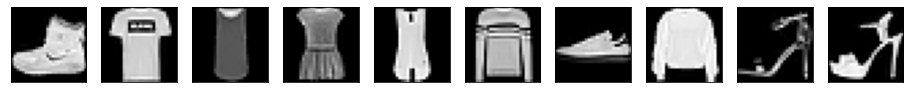

In [ ]:
# Train Data
plt.figure(figsize=(16, 10))
for i in range(num_of_class):
    ax = plt.subplot(1, num_of_class, i+1)
    plt.imshow(x_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
print('== Before normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

## Dataset Pre-processing ##
# Normalization
x_train = x_train/255.  
x_test = x_test/255. 

# Reshape(Adding channel)
x_train = x_train.reshape((size_of_train, 28, 28, 1))
x_test = x_test.reshape((size_of_test, 28, 28, 1))

print('\n== After normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

== Before normalization ==
Image Shape: (28, 28)
Value MIN: 0, MEAN:97.25, MAX:255

== After normalization ==
Image Shape: (28, 28, 1)
Value MIN: 0, MEAN:0.38, MAX:1


In [ ]:
def channel_attention(x, name):
  ####Fill your code####
  inputs = x 
  x = tf.keras.layers.GlobalAveragePooling2D(name = name + "_gap")(x) # Channel의 Attention feature map을 만들기 위한 GlobalAveragingPool, GAP
  n_channels = x.shape[1]
  x = tf.keras.layers.Dense(n_channels //2 , activation='relu', name = name + "_dense1")(x) # bottleneck, fc1
  x = tf.keras.layers.Dense(n_channels, activation='sigmoid', name = name + "_dense2")(x) # channel attention, fc2
  x = tf.keras.layers.multiply([inputs,x]) # element-wise multiply
  return  x

def spatial_attention(x, name):
  inputs = x
  x = tf.keras.layers.Conv2D(filters=1, kernel_size=3, activation='sigmoid', padding='same', name = name+"_conv")(x) # Spatial 정보를 강조하기 우해 conv3x3, filters = 1
  x = tf.keras.layers.multiply([inputs,x]) #element-wise multiply
  return x

 
def autoencoder_block(x, filter, name): 
  x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3, strides=(1, 1), padding='same', name=name+'_conv')(x)
  x = tf.keras.layers.BatchNormalization(name=name+'_bn')(x)
  x = tf.keras.layers.ReLU(name=name+'_relu')(x)
  return x

def attention_module(x, attention_type,name):
  if attention_type is 'channel':
    # Channel Attnetion only
    x = channel_attention(x, attention_type+name)
    output = x
  elif attention_type is 'spatial':
    # Spatial Attention only
    x = spatial_attention(x, attention_type+name)
    output = x
  elif attention_type is 'parellel_add':
    # Parelle Attention (Add)
    x_c_a = channel_attention(x, attention_type+name)
    x_s_a = spatial_attention(x, attention_type+name)
    x = tf.keras.layers.add([x_c_a, x_s_a])
    output = x

  elif attention_type is 'parellel_mul':
    # Parelle Attention (Mul)
    x_c_a = channel_attention(x, attention_type+name)
    x_s_a = spatial_attention(x, attention_type+name)
    x = tf.keras.layers.multiply([x_c_a, x_s_a])
    output = x


  elif attention_type is 'serial_ca':
    # Serial Attention, CA first
    x = channel_attention(x, attention_type+name)
    x = spatial_attention(x, attention_type+name)
    output = x

  elif attention_type is 'serial_sa':
      # Serial Attention, SA first
    x = spatial_attention(x, attention_type+name)
    x = channel_attention(x, attention_type+name)
    output = x

  else: # None Attention
    output  = x
  
  return output

In [ ]:
##############################################
# Add Attention Block in AutoEncoder network #
##############################################

def autoencoder(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img

def model_builder(input, attention):
  # Encoder
  x = autoencoder_block(input, 16, 'encoder1')
  x = attention_module(x, attention, '_attention_encoder1')

  x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
  x = autoencoder_block(x, 32, 'encoder2')
  x = attention_module(x, attention,'_attention_encoder2')

  x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
  
  x = autoencoder_block(x, 64, 'encoder3')
  encoded_img = attention_module(x, attention,'_attention_encoder3')

  # Decoder
  x = autoencoder_block(encoded_img, 64, 'decoder1')
  x = attention_module(x, attention,'_attention_decoder1')

  x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
  x = autoencoder_block(x, 32, 'decoder2')
  x = attention_module(x, attention,'_attention_decoder2')

  x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
  x = autoencoder_block(x, 16, 'decoder3')
  x = attention_module(x, attention,'_attention_decoder3')

  decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                        activation='sigmoid', padding='same', 
                                        name='last_conv')(x)
  return decoded_img    

# Normal AutoEncoder Model Create / Summary
input_data = tf.keras.Input(shape=(28, 28, 1))

output_data = autoencoder(input_data)
output_channel_data = model_builder(input_data, 'channel')
output_spatial_data = model_builder(input_data, 'spatial')
output_parellel_add_data = model_builder(input_data,attention='parellel_add')
output_parellel_mul_data = model_builder(input_data,attention='parellel_mul')
output_serial_ca_data = model_builder(input_data, attention='serial_ca')
output_serial_sa_data = model_builder(input_data, attention='serial_sa')

model = tf.keras.Model(inputs=input_data, outputs=output_data)
model_channel  = tf.keras.Model(inputs=input_data, outputs=output_channel_data)
model_spatial = tf.keras.Model(inputs=input_data,outputs=output_spatial_data)
model_parellel_add = tf.keras.Model(inputs=input_data,outputs=output_parellel_add_data)
model_parellel_mul = tf.keras.Model(inputs=input_data,outputs=output_parellel_mul_data)
model_serial_ca = tf.keras.Model(inputs=input_data,outputs=output_serial_ca_data)
model_serial_sa = tf.keras.Model(inputs=input_data,outputs=output_serial_sa_data)


model.summary()
model_channel.summary()
model_spatial.summary()
model_parellel_add.summary()
model_parellel_mul.summary()
model_serial_ca.summary()
model_serial_sa.summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder1_conv (Conv2D)       (None, 28, 28, 16)        160       
_________________________________________________________________
encoder1_bn (BatchNormalizat (None, 28, 28, 16)        64        
_________________________________________________________________
encoder1_relu (ReLU)         (None, 28, 28, 16)        0         
_________________________________________________________________
encoder_pool1 (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
encoder2_conv (Conv2D)       (None, 14, 14, 32)        4640      
_________________________________________________________________
encoder2_bn (BatchNormalizat (None, 14, 14, 32)        128

In [ ]:
# Model Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])
model_channel.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_spatial.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_parellel_add.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_parellel_mul.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_serial_ca.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_serial_sa.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [ ]:
# Training
print('Training Model')

# AutoEncoder는 input과 output이 같으므로 x_train을 넣어줌
history = model.fit(x_train, x_train, 
                    batch_size=256, 
                    epochs=30,
                    shuffle=True,
                    validation_data=(x_test, x_test))
#Train Channel Attention Model
print('Training Channel Attention Model')

history_channel = model_channel.fit(x_train, x_train, 
                    batch_size=256, 
                    epochs=30,
                    shuffle=True,
                    validation_data=(x_test, x_test))
#Train Spatial Attention Model
print('Training Spatial Attention Model')
history_spatial = model_spatial.fit(x_train, x_train, 
                    batch_size=256, 
                    epochs=30,
                    shuffle=True,
                    validation_data=(x_test, x_test))
#Train Parelle add  Model
print('Training Parelle add  Model')
history_parellel_add = model_parellel_add.fit(x_train, x_train, 
                    batch_size=256, 
                    epochs=30,
                    shuffle=True,
                    validation_data=(x_test, x_test))
#Train Parellel Mul Model
print('Training  Parellel Mul Model')
history_parellel_mul = model_parellel_mul.fit(x_train, x_train, 
                    batch_size=256, 
                    epochs=30,
                    shuffle=True,
                    validation_data=(x_test, x_test))
#Train Serial CA Model
print('Training Serial CA Model')
history_serial_ca = model_serial_ca.fit(x_train, x_train, 
                    batch_size=256, 
                    epochs=30,
                    shuffle=True,
                    validation_data=(x_test, x_test))
#Train Serial SA Model
print('Training Serial SA Model')
history_serial_sa = model_serial_sa.fit(x_train, x_train, 
                    batch_size=256, 
                    epochs=30,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model
Epoch 1/30
235/235 [==============================] - 5s 18ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 2/30
235/235 [==============================] - 4s 17ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 3/30
235/235 [==============================] - 4s 17ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 4/30
235/235 [==============================] - 4s 17ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 5/30
235/235 [==============================] - 4s 17ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 6/30
235/235 [==============================] - 4s 17ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 7/30
235/235 [==============================] - 4s 18ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 8/30
235/235 [==============================] - 

In [ ]:
# Model Predict
recons = model.predict(x_test)
recons_channel = model_channel.predict(x_test)
recons_spatial = model_spatial.predict(x_test)
recons_parellel_add = model_parellel_add.predict(x_test)
recons_parellel_mul = model_parellel_mul.predict(x_test)
recons_serial_ca = model_serial_ca.predict(x_test)
recons_serial_sa = model_serial_sa.predict(x_test)

In [ ]:
recons = recons.reshape(-1, 28, 28)
recons_channel = recons_channel.reshape(-1, 28, 28)
recons_spatial = recons_spatial.reshape(-1, 28, 28)
recons_parellel_add = recons_parellel_add.reshape(-1, 28, 28)
recons_parellel_mul = recons_parellel_mul.reshape(-1, 28, 28)
recons_serial_ca = recons_serial_ca.reshape(-1, 28, 28)
recons_serial_sa = recons_serial_sa.reshape(-1, 28, 28)

test_imgs = (x_test * 255).reshape(-1, 28, 28)

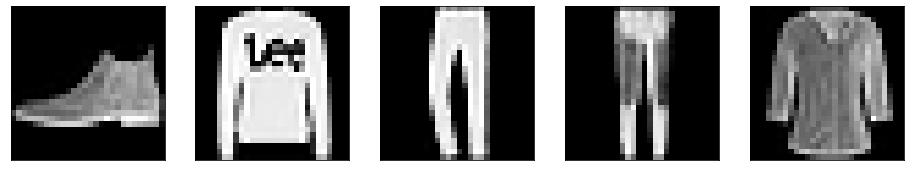

In [ ]:
# Test Data Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(test_imgs[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

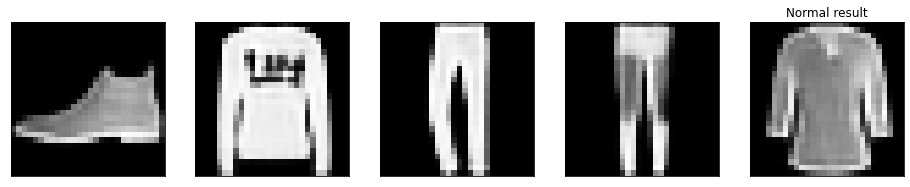

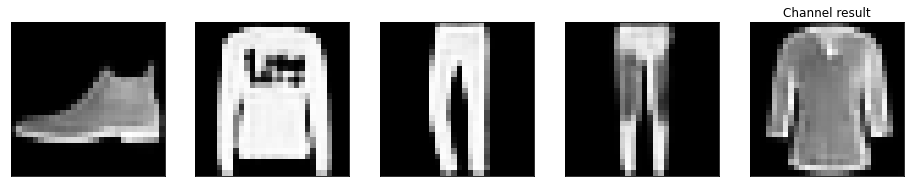

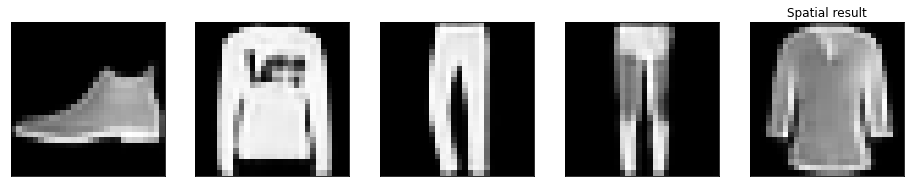

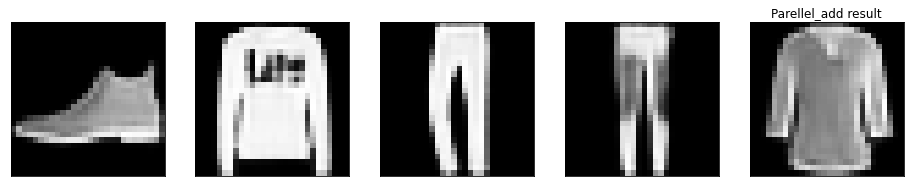

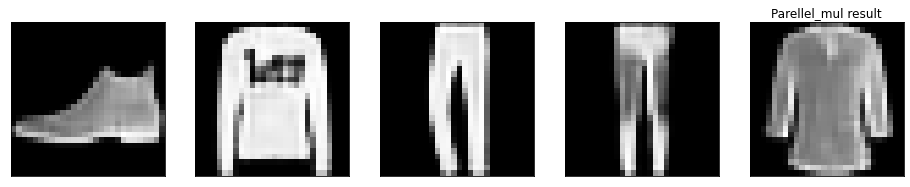

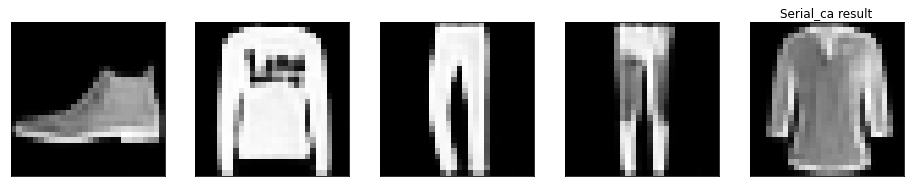

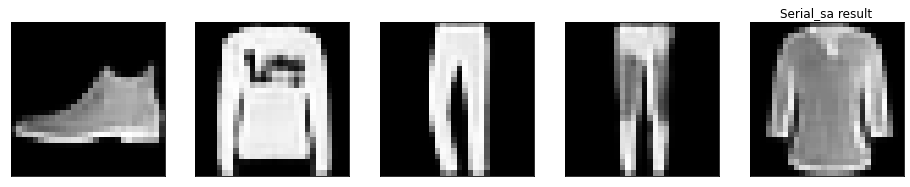

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])
plt.title('Normal result')
plt.show()
fig = plt.figure(figsize=(16, 10))
for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_channel[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])
plt.title('Channel result')
plt.show()

fig = plt.figure(figsize=(16, 10))
for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_spatial[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])
plt.title('Spatial result')
plt.show()

fig = plt.figure(figsize=(16, 10))
for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_parellel_add[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])
plt.title('Parellel_add result')
plt.show()

fig = plt.figure(figsize=(16, 10))
for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_parellel_mul[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])
plt.title('Parellel_mul result')
plt.show()

fig = plt.figure(figsize=(16, 10))
for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_serial_ca[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])
plt.title('Serial_ca result')
plt.show()

fig = plt.figure(figsize=(16, 10))
for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_serial_sa[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])
plt.title('Serial_sa result')
plt.show()

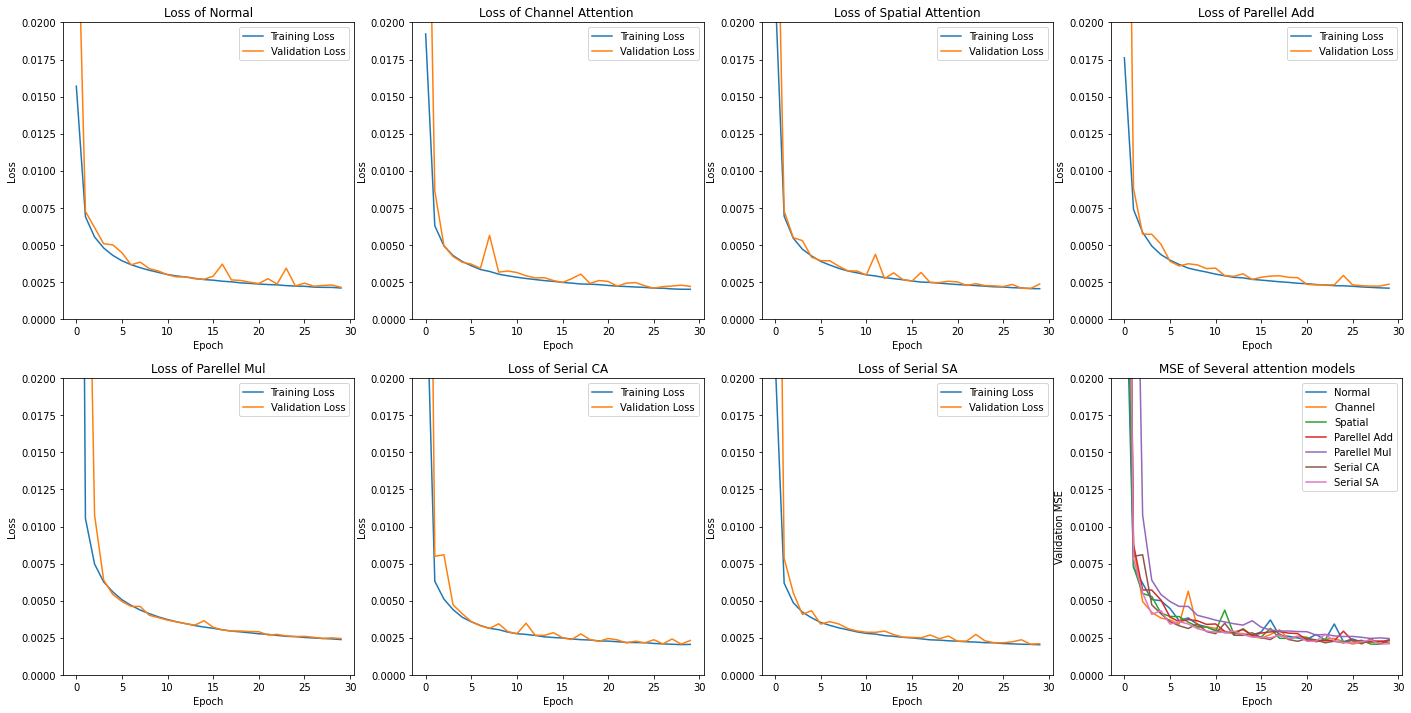

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,12))
plt.subplot(2,4,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of Normal')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim((0, 0.02))
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,2)
plt.plot(history_channel.history['loss'])
plt.plot(history_channel.history['val_loss'])
plt.title('Loss of Channel Attention ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim((0, 0.02))
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,3)
plt.plot(history_spatial.history['loss'])
plt.plot(history_spatial.history['val_loss'])
plt.title('Loss of Spatial Attention')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim((0, 0.02))
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,4)
plt.plot(history_parellel_add.history['loss'])
plt.plot(history_parellel_add.history['val_loss'])
plt.title('Loss of Parellel Add')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim((0, 0.02))
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(2,4,5)
plt.plot(history_parellel_mul.history['loss'])
plt.plot(history_parellel_mul.history['val_loss'])
plt.title('Loss of Parellel Mul')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim((0, 0.02))
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,6)
plt.plot(history_serial_ca.history['loss'])
plt.plot(history_serial_ca.history['val_loss'])
plt.title('Loss of Serial CA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim((0, 0.02))
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,7)
plt.plot(history_serial_sa.history['loss'])
plt.plot(history_serial_sa.history['val_loss'])
plt.title('Loss of Serial SA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim((0, 0.02))
plt.legend(['Training Loss', 'Validation Loss'], loc=0)


plt.subplot(2,4,8)
plt.plot(history.history['val_mse'])
plt.plot(history_channel.history['val_mse'])
plt.plot(history_spatial.history['val_mse'])
plt.plot(history_parellel_add.history['val_mse'])
plt.plot(history_parellel_mul.history['val_mse'])
plt.plot(history_serial_ca.history['val_mse'])
plt.plot(history_serial_sa.history['val_mse'])

plt.title('MSE of Several attention models')
plt.ylabel('Validation MSE')
plt.xlabel('Epoch')
plt.legend(['Normal', 'Channel','Spatial','Parellel Add','Parellel Mul','Serial CA','Serial SA'], loc=0)
plt.ylim((0, 0.02))
plt.show()